---

# AIPI 590 - XAI | Assignment #06
### Akhil Chintalapati

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/templates/template.ipynb)

# Predicting Bike Rentals with PDP, ICE, and ALE

In this notebook, we’re going to predict bike rentals 🚴‍♂️ using a **Random Forest** model. But more importantly, we’re going to dive deep into **why** the model makes the predictions it does using some powerful visualization techniques like **Partial Dependence Plots (PDP)**, **Individual Conditional Expectation (ICE)** plots, and **Accumulated Local Effects (ALE)** plots. These insights will help us figure out how different factors - like temperature, humidity, or windspeed—affect bike rentals. It’s kind of like cracking the code behind your favorite weather app, except, full disclosure, I have no idea how to build the complete frontend for a weather app either!

---

## Step 1: Install and Import Necessary Libraries

Let’s kick things off by getting the tools we need. Think of this step as gathering all your ingredients before you start cooking (Trust me, I can cook better than building the frontend for a weather app).

In [2]:
%pip --quiet install alibi plotly
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
import requests
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.4 MB/s eta 0:00:00


---

## Step 2: Load the Dataset
Before we can start predicting bike rentals, we need the data (Sherlock)! Think of it as the bike-rental log for the entire city. Here’s how we download and load it into our workspace.

In [3]:
# Let's grab the dataset.
# We're using the UCI Bike Sharing Dataset, which has info on daily bike rentals in Washington, D.C.
# Luckily, the dataset is just a URL away :)! We'll download it directly from UCI's machine learning repository.

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
response = requests.get(url)  # Download the dataset, smoothly
zip_file = ZipFile(BytesIO(response.content))  # We can unzip it straight from memory. So convenient.

In [4]:
# We'll focus on the 'day.csv' file for daily bike rental data.
# They gave us a lot of files, but 'day.csv' is our MVP :).

with zip_file.open('day.csv') as file:
    df_day = pd.read_csv(file)

In [5]:
# Time to focus on a few important features.
# There are a bunch of columns in the dataset, but we don’t need all of them for our analysis.
# We’ll stick to features like 'temp', 'humidity', 'windspeed', and 'season' which seem pretty bike-relevant :).
# Oh, and we'll rename 'cnt' (total count of bikes rented) to 'count'. And 'hum' to 'humidity'. It’s clearer this way!

df_day = df_day[['temp', 'atemp', 'hum', 'windspeed', 'season', 'workingday', 'cnt']]  # Only the essentials.
df_day.rename(columns={'cnt': 'count'}, inplace=True)  # Simple is better!
df_day.rename(columns={'hum': 'humidity'}, inplace=True)  # 'hum' sounds bad honestly

In [6]:
df_day

,temp,atemp,humidity,windspeed,season,workingday,count
0,0.344167,0.363625,0.805833,0.160446,1,0,985
1,0.363478,0.353739,0.696087,0.248539,1,0,801
2,0.196364,0.189405,0.437273,0.248309,1,1,1349
3,0.200000,0.212122,0.590435,0.160296,1,1,1562
4,0.226957,0.229270,0.436957,0.186900,1,1,1600
...,...,...,...,...,...,...,...
726,0.254167,0.226642,0.652917,0.350133,1,1,2114
727,0.253333,0.255046,0.590000,0.155471,1,1,3095
728,0.253333,0.242400,0.752917,0.124383,1,0,1341
729,0.255833,0.231700,0.483333,0.350754,1,0,1796


---

## Step 3: Exploratory Data Analysis (EDA) - let's investigate!

Before jumping into fancy plots like PDP, ICE, and ALE, let’s first understand how these features relate to each other.

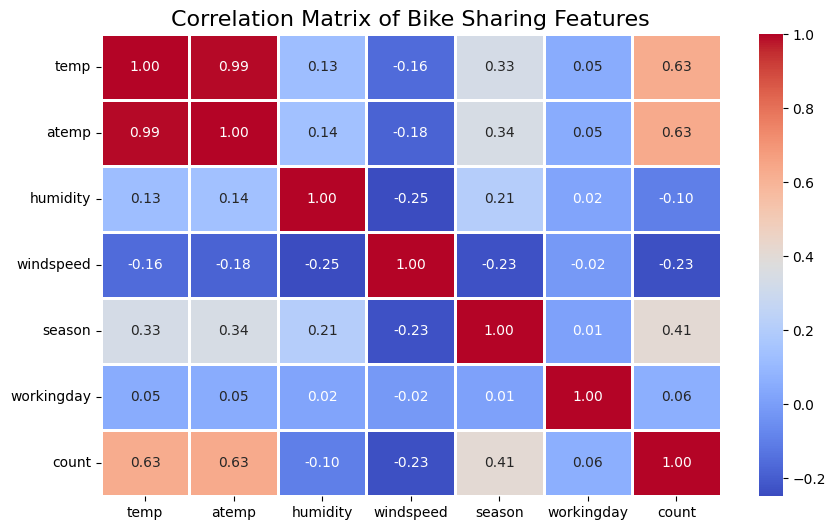

In [7]:
# A correlation matrix is basically a heatmap that tells us how features move together.

# This is useful to spot any multicollinearity (when features are too similar) that could mess with our models.

plt.figure(figsize=(10, 6))  # Let’s make the heatmap large enough to admire 😍
sns.heatmap(df_day.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title("Correlation Matrix of Bike Sharing Features", fontsize=16)
plt.show()

Ooooh, that’s a pretty picture (the colour combination)! But let’s focus on what it’s actually telling us:
- 'Temp' (temperature) has a **strong positive correlation** with 'count' (about 0.63), meaning more people rent bikes when it’s warm.
Not a shocker—people love biking on sunny, pleasant days!
- 'Atemp' (apparent temperature) is basically 'temp's twin with a correlation of 0.99. 😲 They’re super similar,
which could lead to **multicollinearity**—that’s when features are too related and confuse the model.
- 'Humidity' and 'windspeed' have **negative correlations** with 'count' (makes sense, no one wants to bike through a sticky, humid day or battle gusty winds).
- 'Season' has a positive correlation with 'count' too (0.41)—perhaps people rent more bikes during certain seasons, like spring or summer?
- 'Workingday' doesn’t seem to matter much in terms of rentals (barely any correlation).

All this to say: temperature is a major driver for bike rentals, but we’ll need to watch out for 'temp' and 'atemp' being too alike
(because when features are too correlated, models can get confused on which one is doing the heavy lifting).

In [ ]:
# Basic Information:
# This gives us a snapshot of our dataset. It shows that we have 731 entries (rows) and 7 columns (features).
# We also see that there are no missing values, which is great! It saves us from having to clean the data (Yay, less time on this project).

print("Basic Information:")
print(df_day.info())  # Checking the structure of the dataset

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        731 non-null    float64
 1   atemp       731 non-null    float64
 2   humidity    731 non-null    float64
 3   windspeed   731 non-null    float64
 4   season      731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   count       731 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 40.1 KB
None


In [8]:
# Descriptive Statistics:
# This gives us a summary of the dataset's numerical features. A few things stand out:
# - 'Temp' and 'atemp' (temperature and apparent temperature) have similar ranges, with mean values around 0.49 and 0.47 respectively.
#   These are scaled between 0 and 1 (representing normalized values).
# - 'Humidity' is also normalized and has a mean around 0.63, meaning most days are quite humid.
# - 'Windspeed' shows a much smaller range (0 to 0.5), with a relatively low mean of 0.19. It seems there aren’t many super windy days!
# - 'Count' (bike rentals) shows a wide range, from just 22 bikes rented on the least busy day to 8714 bikes on the busiest.

print("\nDescriptive Statistics:")
print(df_day.describe())  # Summary statistics of the numerical columns


Descriptive Statistics:
             temp       atemp    humidity   windspeed      season  workingday  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
mean     0.495385    0.474354    0.627894    0.190486    2.496580    0.683995   
std      0.183051    0.162961    0.142429    0.077498    1.110807    0.465233   
min      0.059130    0.079070    0.000000    0.022392    1.000000    0.000000   
25%      0.337083    0.337842    0.520000    0.134950    2.000000    0.000000   
50%      0.498333    0.486733    0.626667    0.180975    3.000000    1.000000   
75%      0.655417    0.608602    0.730209    0.233214    3.000000    1.000000   
max      0.861667    0.840896    0.972500    0.507463    4.000000    1.000000   

             count  
count   731.000000  
mean   4504.348837  
std    1937.211452  
min      22.000000  
25%    3152.000000  
50%    4548.000000  
75%    5956.000000  
max    8714.000000  


In [10]:
# Correlation Matrix:
# Here, we’re particularly interested in how features correlate with our target variable 'count'.
# Sorting by correlation with 'count' shows that:
# - 'atemp' (apparent temperature) and 'temp' have the strongest positive correlation with bike rentals (around 0.63).
#   This tells us that warmer days lead to more bike rentals, which makes sense!
# - 'Season' has a moderate correlation (0.41), likely because more people bike in the spring and summer.
# - 'Workingday' has a very weak correlation (0.06), meaning it doesn’t significantly affect rentals.
# - On the flip side, 'humidity' and 'windspeed' are negatively correlated, especially windspeed (-0.23). This suggests people avoid biking on windy days!

# Calculate the correlation matrix and assign it to corr_matrix
corr_matrix = df_day.corr()

target_corr = corr_matrix['count'].sort_values(ascending=False)
print("\nCorrelations with target variable (count):")
print(target_corr)


Correlations with target variable (count):
count         1.000000
atemp         0.631066
temp          0.627494
season        0.406100
workingday    0.061156
humidity     -0.100659
windspeed    -0.234545
Name: count, dtype: float64


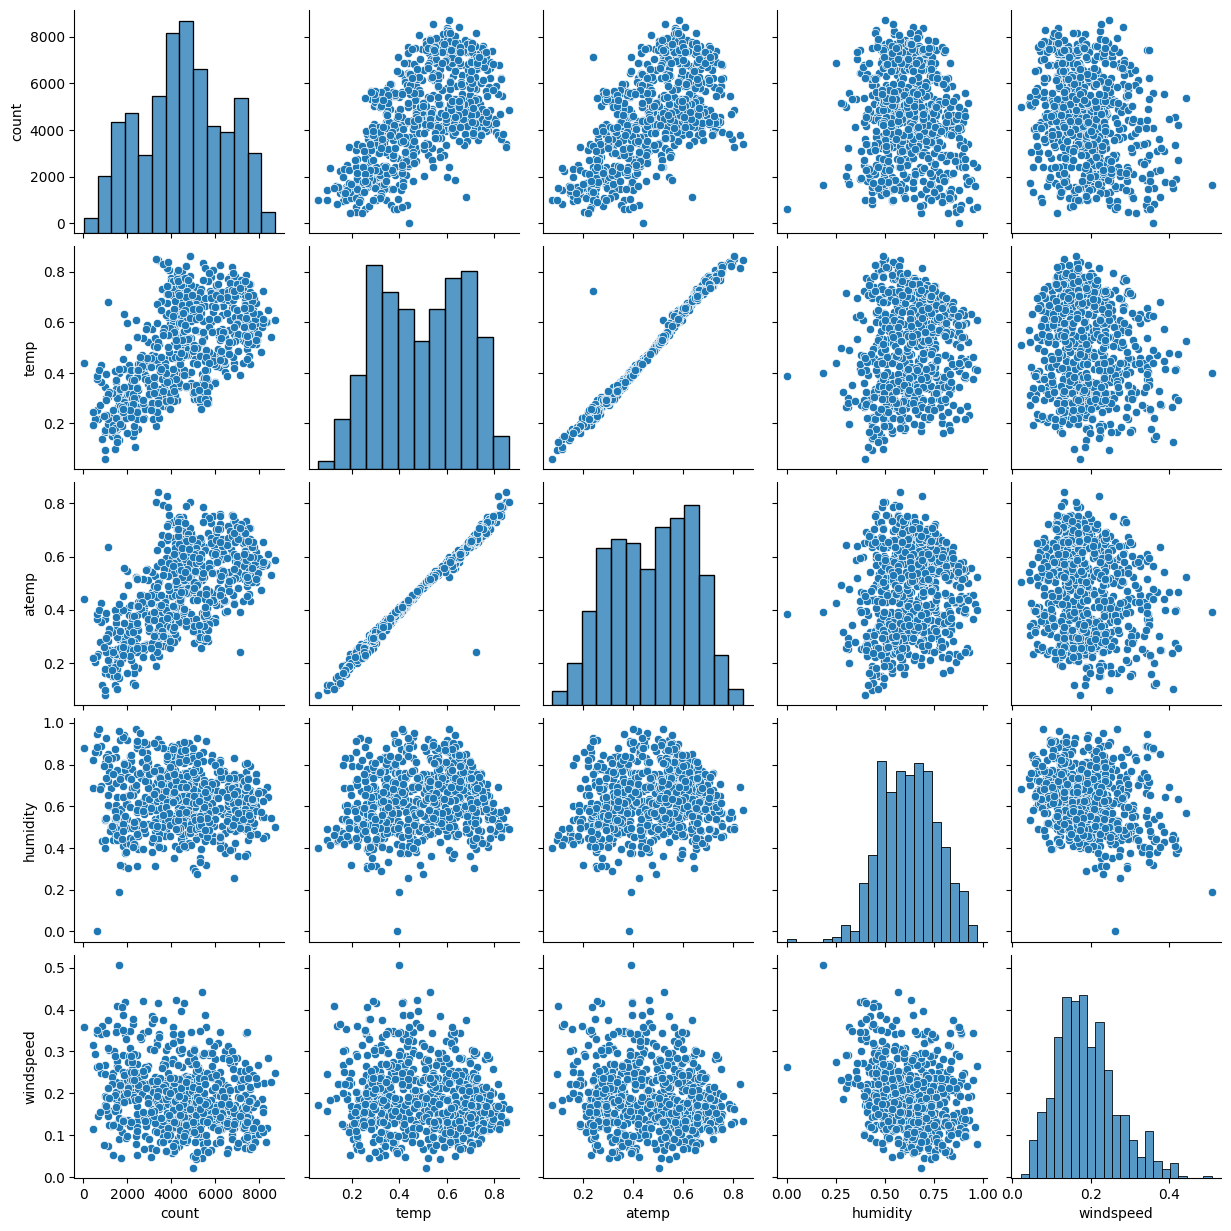

In [11]:
# Pair Plot:
# The pair plot helps us visualize relationships between pairs of features. What stands out here:
# - 'Temp' and 'atemp' show an almost perfect linear relationship, which we already suspected from the high correlation (99% in the heatmap).
# - 'Count' has a clear positive relationship with both 'temp' and 'atemp', confirming that higher temperatures lead to more bike rentals.
# - For 'humidity' and 'windspeed', the scatter is more spread out, and we don’t see strong patterns with 'count'. This aligns with the low correlations we saw earlier.

sns.pairplot(df_day[['count', 'temp', 'atemp', 'humidity', 'windspeed']])
plt.show()

---

## Step 4: Train the Random Forest Model 🌳

In [12]:
# Define our features (inputs) and the target (output)
# X is everything except the target ('count'), and y is our target (bike rental count).
# Basically, we're trying to predict how many bikes are rented based on stuff like temperature, humidity, and windspeed!
X = df_day.drop(columns=['count'])  # Features (things that affect rentals)
y = df_day['count']  # Target (how many bikes were rented)

# Time to split the data!
# We're keeping 80% of the data for training the model and 20% for testing (to see if the model works on new data).
# It's like using 80% of past bike rental days to predict the remaining 20%.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Let’s build the model 🚴‍♂️
# We're using a Random Forest (think of it as a bunch of decision trees working together to make predictions).
# It's like asking 100 smart friends (everyone except me :)) to guess the bike rentals and taking the average. The more trees, the more robust the prediction (more greenery too, yay!).

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)  # Train the model on 80% of the data

RandomForestRegressor(random_state=42)

---

## Step 5: Interpret the Results with PDP, ICE, and ALE!

In [14]:
# We're going to focus on temperature, humidity, and windspeed, because who wouldn’t want to know how these affect bike rentals, right?
features_to_plot = ['temp', 'humidity', 'windspeed']

# Creating Partial Dependence Plots (PDP) data manually
# The PDP shows us how changing one feature (like temp) affects the bike rentals, while keeping all other factors constant.
pdp_data = {}
for feature in features_to_plot:
    # We're going to test a range of values for each feature (like all possible temperatures from low to high).
    feature_values = np.linspace(X_train[feature].min(), X_train[feature].max(), 100)
    pdp_predictions = []

    # For each feature value (e.g., different temperatures), we ask, "What would the bike rentals look like if temperature stayed at this value?"
    for val in feature_values:
        X_test_copy = X_test.copy()
        X_test_copy[feature] = val
        pdp_predictions.append(model.predict(X_test_copy).mean())  # Predict bike rentals and store the average prediction

    # Store the feature values and corresponding predictions
    pdp_data[feature] = (feature_values, pdp_predictions)

In [15]:
# Generate ICE (Individual Conditional Expectation) data for 'temp' 🥶 -> 🔥
# ICE is like PDP but for individual data points. It’s like seeing how each person's bike rental behavior changes as temp changes.

temp_values = np.linspace(X_train['temp'].min(), X_train['temp'].max(), 100)  # Different temperature values
ice_data = np.zeros((X_test.shape[0], len(temp_values)))  # We'll store ICE data here for each test point

# For each temperature value, we check how predictions change for every test point.
for i, val in enumerate(temp_values):
    X_test_copy = X_test.copy()  # Copy the test data
    X_test_copy['temp'] = val  # Set 'temp' to a constant value (like setting the thermostat)
    ice_data[:, i] = model.predict(X_test_copy)

In [16]:
# Time for ALE (Accumulated Local Effects) 🌐
# ALE is a fancier version of PDP that accounts for interactions between features. It’s more localized and can handle correlations between features better.

# We're going to explain how 'temp', 'humidity', and 'windspeed' impact the predictions.
ale = ALE(model.predict, feature_names=X_train.columns)

# Let ALE explain the effects for the selected features. It’s like an advanced breakdown of how each feature impacts bike rentals.
exp = ale.explain(X_test.values, features=[X_test.columns.get_loc(f) for f in features_to_plot])

In [17]:
# Plot PDP using Plotly 📊
# We're creating interactive PDP plots for 'temp', 'humidity', and 'windspeed'.
pdp_fig = make_subplots(rows=1, cols=3, subplot_titles=features_to_plot)

for i, feature in enumerate(features_to_plot):
    pdp_fig.add_trace(
        go.Scatter(x=pdp_data[feature][0], y=pdp_data[feature][1], mode='lines', name=f'PDP for {feature}'),
        row=1, col=i+1
    )

pdp_fig.update_layout(title_text="Interactive Partial Dependence Plots (PDP)", showlegend=False)
pdp_fig.show()  # Show the PDP plot for each feature!


In [18]:
# Plot ICE for temperature 🌡️
# We’re plotting how individual data points react to changes in temperature. Each line represents one person's behavior as temperature shifts.
ice_fig = go.Figure()

for i in range(ice_data.shape[0]):
    ice_fig.add_trace(
        go.Scatter(x=temp_values, y=ice_data[i], mode='lines', line=dict(color='blue', width=1), opacity=0.2)
    )

ice_fig.update_layout(title='Interactive ICE Plot for temp', xaxis_title='temp', yaxis_title='Predicted Bike Count')
ice_fig.show()


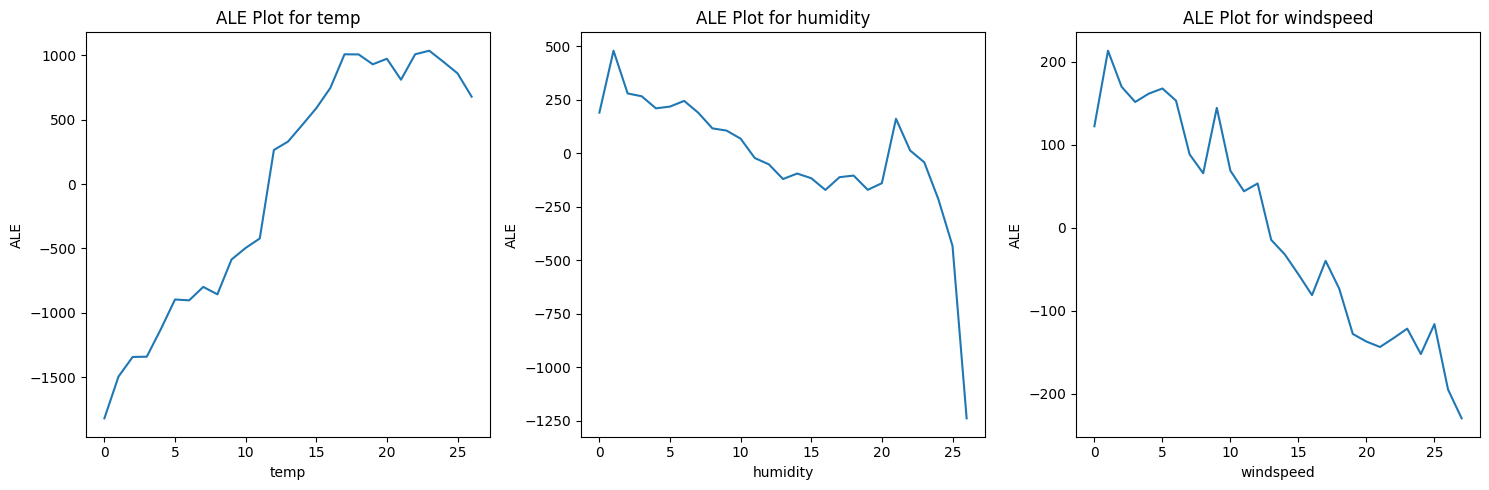

In [19]:
# Plot ALE for 'temp', 'humidity', and 'windspeed' 🚀
# We're creating subplots for the ALE plots of each feature. It’s the most advanced plot of the bunch!
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.plot(exp.ale_values[i])  # Plot the ALE values for each feature
    ax.set_title(f'ALE Plot for {features_to_plot[i]}')
    ax.set_xlabel(features_to_plot[i])
    ax.set_ylabel('ALE')
plt.tight_layout()
plt.show()

---

## Explanation of the Plots

## 1. ALE (Accumulated Local Effects) Plots

**What is ALE?**
- ALE is a method for interpreting machine learning models that shows the isolated effect of a feature on the model’s predictions. It’s often considered more robust than PDP because it handles correlated features better by focusing on localized changes in the data.

### ALE for Temperature (`temp`)
- **Interpretation**: The ALE plot for `temp` shows that as the temperature increases, bike rentals also increase sharply, especially between the temperature range of 5 to 20. After 20, the effect seems to reduce off slightly.
- **Interesting Finding**: There’s a clear sweet spot for temperature. When temperatures rise beyond 20 (scaled), the effect on bike rentals slightly plateaus, suggesting that very high temperatures might not continue to increase rentals, or that people may reach a threshold for comfort in biking.

### ALE for Humidity (`humidity`)
- **Interpretation**: The ALE plot for `humidity` shows a negative relationship with bike rentals. Initially, the ALE value increases, but then it sharply drops after a certain point (around 10-15). High humidity (beyond 20 on the plot) seems to have a very strong negative effect on bike rentals.
- **Interesting Finding**: Humidity has a clear negative impact on rentals as it gets higher. This aligns with common sense – cycling in hot, sticky weather might not be appealing to people.

### ALE for Windspeed (`windspeed`)
- **Interpretation**: The ALE plot for `windspeed` reveals that higher wind speeds tend to decrease bike rentals. The drop is steady, with no sharp increases, showing a consistent negative effect.
- **Interesting Finding**: People generally avoid biking on windier days. The stronger the wind, the fewer the rentals – not a surprising finding, but this gives us more insight into how significant that effect is.

---

## 2. ICE (Individual Conditional Expectation) Plot for `temp`

**What is ICE?**
- ICE plots show how each individual prediction changes as a feature (in this case, `temp`) varies. Unlike PDPs, which show the average effect, ICE plots reveal how different individual instances in the dataset respond to changes in a feature.

### ICE for Temperature (`temp`)
- **Interpretation**: The ICE plot shows a set of individual lines representing how predictions change for each test point as the temperature increases. Most lines show a gradual upward trend, indicating that as temperature rises, bike rentals tend to increase.
- **Interesting Finding**: We can see individual variability here – some lines have steeper upward trends than others. This suggests that while the overall trend is that higher temperatures lead to more rentals, the strength of that effect varies for different observations. Some days see a bigger boost in rentals with warmer weather than others.

---

## 3. PDP (Partial Dependence Plot)

**What is PDP?**
- PDP shows the **average** effect of a feature on the model’s predictions while keeping all other features constant. It’s simpler than ALE and ICE but less accurate when features are correlated.

### PDP for Temperature (`temp`)
- **Interpretation**: The PDP shows a similar trend to the ALE plot, with bike rentals increasing sharply as the temperature rises from around 0.3 to 0.6 (scaled temperature). After 0.6, the effect seems to stabilize, with bike rentals reaching a plateau.
- **Interesting Finding**: The PDP shows a clear upward trend in rentals with temperature, but it's smoother compared to ALE and ICE. PDP averages out individual variability, making it less detailed.

### PDP for Humidity (`humidity`)
- **Interpretation**: The PDP shows that bike rentals remain relatively stable until the humidity reaches about 0.4, after which rentals start to drop significantly.
- **Interesting Finding**: Similar to the ALE plot, the PDP indicates that high humidity has a significant negative impact on bike rentals.

### PDP for Windspeed (`windspeed`)
- **Interpretation**: The PDP for `windspeed` shows that as wind speed increases, bike rentals decrease consistently.
- **Interesting Finding**: This matches the ALE plot, reinforcing that windier days deter bike rentals.

---

## Key Differences Between ALE and PDP

1. **Treatment of Correlated Features**:
   - **PDP** assumes that features are independent, so it may give biased results when features are correlated. In our data, features like `temp` and `humidity` may have some correlation. This can make PDP overestimate or underestimate the impact of a feature.
   - **ALE** handles feature correlations better by looking at local changes, which provides more nuanced insights into how each feature impacts the model’s predictions.
   - **Example**: In the case of temperature (`temp`), the ALE plot shows a more complex trend with localized changes, while the PDP plot shows a smoother trend, which might oversimplify the effect.

2. **Detail and Variability**:
   - **PDP** averages the impact across all data points, which can hide individual differences. This is why the PDP for `temp` looks smoother than the ICE plot.
   - **ALE** and **ICE** reveal more variability and detail in how different instances behave. ICE shows individual trends for each test point, while ALE captures localized feature interactions.

---

## Correlation and its Impact

During the exploratory data analysis (EDA), we observed that `temp` and `atemp` (apparent temperature) had almost perfect correlation, while features like `windspeed` and `humidity` were less strongly correlated with each other and the target (`count`).

- **Impact on PDP**: The strong correlation between `temp` and `atemp` means PDP might not give the most reliable insights because it doesn't handle feature correlations well.
- **Impact on ALE**: ALE, on the other hand, accounts for feature interactions and correlations. This is why the ALE plots might show more complex patterns or different behavior than PDP. For instance, ALE for `temp` shows more variation and localized effects, while PDP smooths over these interactions.

---

## Final Summary

- **Temperature**: All three methods (ALE, PDP, and ICE) show that temperature has a significant positive impact on bike rentals. Warmer temperatures lead to more rentals, but there is a plateau effect where rentals stop increasing after a certain point.
- **Humidity**: Higher humidity leads to fewer rentals, especially as humidity crosses a certain threshold.
- **Windspeed**: Both ALE and PDP reveal that higher wind speeds consistently decrease bike rentals.

Overall, ALE gives us a more detailed and accurate understanding of how each feature affects the model’s predictions by accounting for interactions and correlations, while ICE provides insights into individual prediction variability. PDP is useful for seeing the general trend but might miss some of the nuances due to feature correlations.

---